In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
!gc-monitor

+---------------+--------------------------------------------------------------+
|  gc-monitor   |   Partition: 'mkbahk-pt-16ipus' has 16 reconfigurable IPUs   |
+-------------+--------------------+----------+------+--------------+----+---------+-------+-------+
|    IPU-M    |       Serial       |  ICU FW  | Type |Server version| ID | PCIe ID |Routing| GWSW  |
+-------------+--------------------+----------+------+--------------+----+---------+-------+-------+
|  10.1.5.1   | 0072.0002.8204121  |  2.3.2   |M2000 |    1.7.1     | 0  |    3    |  DNC  | 2.2.0 |
|  10.1.5.1   | 0072.0002.8204121  |  2.3.2   |M2000 |    1.7.1     | 1  |    2    |  DNC  | 2.2.0 |
+-------------+--------------------+----------+------+--------------+----+---------+-------+-------+
|  10.1.5.1   | 0072.0001.8204121  |  2.3.2   |M2000 |    1.7.1     | 2  |    1    |  DNC  | 2.2.0 |
|  10.1.5.1   | 0072.0001.8204121  |  2.3.2   |M2000 |    1.7.1     | 3  |    0    |  DNC  | 2.2.0 |
+-------------+---------------

In [3]:
!pwd
#!pip3 install pydot 
#!pip3 install matplotlib

/home/mkbahk


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python import ipu

In [5]:
#!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip


In [6]:
#!unzip -q -o kagglecatsanddogs_3367a.zip
!ls ./PetImages

Cat  Dog


In [7]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        ###end of try:

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
        ###end of if:
    ###end of for:
###end of for:
        

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [8]:
image_size = (180, 180)
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


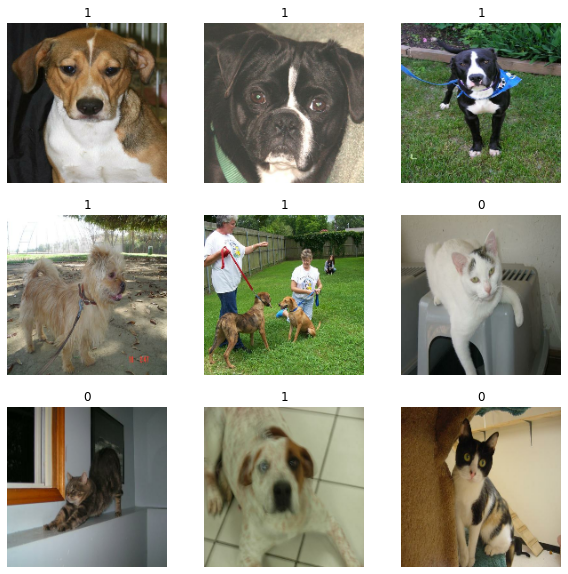

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
    ###end of for:
###end of for:

In [10]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        # layers.experimental.preprocessing.RandomRotation(0.1),
        # random rotation은 지원이 안됨
    ]
)

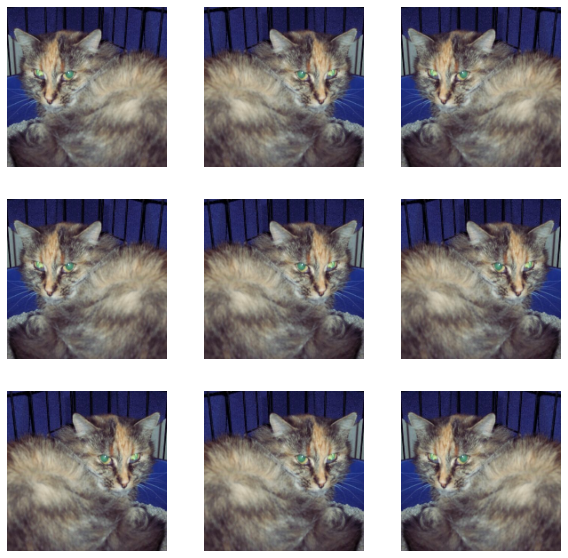

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
    ###end of for:
###end of for:

In [12]:
###지웅님이 IPU를 위해 추가한 내역
train_ds = train_ds.unbatch().batch(batch_size=16, drop_remainder=True)
val_ds = val_ds.unbatch().batch(batch_size=16, drop_remainder=True)
###

train_ds = train_ds.prefetch(buffer_size=16)
val_ds = val_ds.prefetch(buffer_size=16)

In [13]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual
    ###end of for:

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    ###end of if:

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)
###end of def:

#keras.utils.plot_model(model, show_shapes=True)  

In [14]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

def main():
    if __name__ == '__main__':

        config = ipu.config.IPUConfig()
        config.auto_select_ipus = 16
        config.configure_ipu_system()

        strategy = ipu.ipu_strategy.IPUStrategy()
        with strategy.scope():

            model = make_model(input_shape=image_size + (3,), num_classes=2)
          
            model.compile(
                optimizer=keras.optimizers.Adam(1e-3),
                loss="binary_crossentropy",
                metrics=["accuracy"],
                steps_per_execution=16
                # steps_per_execution은 IPU 개수 (=16)의 배수이어야 함
            )
            model.fit(
                train_ds, 
                epochs=epochs, 
                callbacks=callbacks, 
                validation_data=val_ds,
                steps_per_epoch=1456
                #steps_per_epoch=728
                # steps_per_epoch은 steps_per_execution의 배수이어야 함
                # steps_per_epoch은 전체 배치 수 (= 전체 샘플 수 // batch size = 23410 // 32 = 731) 보다 작거나 같아야 함
                # 이 중 가장 큰 것은 728
            )
        ###end of with:
    ###end of if:
###end of def:

if __name__ == '__main__':
    main()
    

INFO:tensorflow:The provided set of data has an unknown size. This can result in runtime errors if not enough data is provided during execution.
INFO:tensorflow:The model `model` has been configured with only 16 steps per execution (1 steps per execution per replica). Consider increasing the value for the `steps_per_execution` argument passed to the `compile()` method to improve performance.
Epoch 1/50


InternalError: [Poplar][Compile engine] poplar_error: Out of memory on tile 0: 1375544 bytes used but tiles only have 638976 bytes of memory [Op:__inference_train_function_5779]

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

In [ ]:
###end of code